### To_Do's:

[ ] Write the ways we can deal with the scenario where a gene has value outside the wanted range.

[ ] Write s little more about the genetic algorithms in the beginning, as well as a little overview about the project.

[ ] Re-read the texts and make sure they are in a nice order

## Computational Intelligence: Genetic Algorithms Project. 

In a broad sense, Genetic Algorithms can be defined as population based models that
use selection and recombination operators to generate new sample points ina search space. The idea of Genetic Algorithms are heavily infuenced by the Theory of Evolution, by encoding potential solutions to a specific problem into simple chromosome-like data structure and apply recombination operators to these structures, as to preserve critical information.  


In [1]:
import pandas as pd
import numpy as np 
from difflib import get_close_matches
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import utils as ul
import importlib
importlib.reload(ul)

<module 'utils' from 'c:\\Users\\kwnka\\vs-code projects\\CompIntel\\project_B\\utils.py'>

### Preprocessing

1. **Loading**: To start off the dataset is loaded into a Pandas dataframe and some information is printed using the `print_dataframe_info()` function, to help understand the data better. Then we filter the dataframe, keeping the data having `region_main_id == 1693`. This means that only the inscriptions of a particular region are kept, which have a generally higher chance to have similar content.
2. **BoW with Tf-Idf**: In order to implement the Bag of Words model using tf-idf vectorization, the following steps are performed:
    * An object of the `TfidfVectorizer()` Class is instantiated.
    * The method `fit_transform()` of the Class is used in order for the vocabulary to be constructed and for the inscriptions to be transformed into the aprropriate form.
    * The **output** of the vectorizer is a **sparse matrix**, where the rows are the different inscriptions and columns the different features of the vocabulary. A value in a particular position of the matrix signifies the existance of the particular feature in that inscription.
3. **Target Inscription**: Since the damaged inscription that needs to be filled is not part of the dataset, the word *αλεξανδρε* does not exist in the vocabulary built using the BoW, so it is replaced by the closest related word in the dictionary, the word *ανδρες*, which is found using the `get_close_matches(missing_word, vocab, n=1)` command from the `difflib` library, where:
    * **missing word**: Is the word that is missing, so the word *αλεξανδρε*.
    * **vocab**: Is the vocabulary obtained from the `print_vectorizer_info()` function.
    * **n=1**: Signifies that the closest possible word to the missing word should be returned.
    
So the new target inscription after this procedure is [...]*ανδρες ουδις*[...], which is then tranformed into a tf-idf vector using the same vectorizer as before.

The three seperate steps of the preprocessing can be seen below:

In [2]:
# Load dataset into a dataframe and print information about it
df = pd.read_csv('iphi2802.csv', delimiter='\t')

ul.print_dataframe_info(df)

df_filtered= df.query("region_main_id == 1693")


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              2802 non-null   int64  
 1   text            2802 non-null   object 
 2   metadata        2802 non-null   object 
 3   region_main_id  2802 non-null   int64  
 4   region_main     2802 non-null   object 
 5   region_sub_id   2802 non-null   int64  
 6   region_sub      2802 non-null   object 
 7   date_str        2802 non-null   object 
 8   date_min        2802 non-null   float64
 9   date_max        2802 non-null   float64
 10  date_circa      2802 non-null   float64
dtypes: float64(3), int64(3), object(5)
memory usage: 240.9+ KB

Number of NULL values per column:
id                0
text              0
metadata          0
region_main_id    0
region_main       0
region_sub_id     0
region_sub        0
date_str          0
date_min          0
date_ma

In [3]:
# Initalize the tf-idf Vectorizer 
vectorizer = TfidfVectorizer()
index_matrix = vectorizer.fit_transform(df_filtered['text'].to_list()).toarray()

vocab_dict = ul.print_vectorizer_info(vectorizer, index_matrix, True)

The dictionary of the dataset: ['αβ' 'αββεος' 'αβδαασθωρης' ... 'ϙε' 'ϙτ' 'ϛπ']
The shape of the output matrix: (127, 1678)
The matrix: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
The unique values of the output matrix: [0.         0.01130775 0.01235026 0.01388891 0.01461941 0.01556119
 0.01688855 0.02016224 0.02100191 0.0212497  0.02392936 0.02777781
 0.02923882 0.03060018 0.03112238 0.0330687  0.03345886 0.03377711
 0.03527057 0.03589404 0.03631753 0.03748793 0.03836221 0.03881482
 0.03987613 0.04166672 0.04215832 0.04385823 0.04437568 0.04668357
 0.04723436 0.04911755 0.04940106 0.05066566 0.05099229 0.05126343
 0.05146199 0.05316818 0.05515732 0.05555563 0.05774379 0.06008614
 0.06048671 0.06175797 0.06248299 0.06297707 0.06493779 0.06499394
 0.06604416 0.06754861 0.06755421 0.06778379 0.06920439 0.06933822
 0.06944454 0.06971857 0.07178808 0.07198476 0.07221305 0.0730970

In [4]:
# Find the word closest to the missing word 'αλεξανδρε' and turn the incomplete inscription into a tf-idf vector
missing_word = 'αλεξανδρε'
replaced_word = get_close_matches(missing_word, vocab_dict.values(), n=1)
print(f"The word closest to the missing word: {replaced_word[0]}")
replaced_inscription = f'{replaced_word[0]} ουδις'
print(f"The new inscription: {replaced_inscription}")
incomplete_vector = vectorizer.transform([replaced_inscription]).toarray()

The word closest to the missing word: ανδρες
The new inscription: ανδρες ουδις


### Encoding of chromosomes & Fitness Function

* **Encoding**: Firstly, the chromosomes of the population, consist of two different genes, one for each word that is missing. For this project the different genes, hence the chromosomes of the population are encoded using integer value encoding. Since the dictionary of this project consists of 1678 different features, the different values of a gene will be 0-1677. The final chromosome is a tuple consisting of two numbers, which are the indexes of the words in the dictionary. 
Using this particular encoding ensures that no values outside of the range 0-1677 will occur. To ensure this, the gene space has been inserted to the constructor of the GA instance.

* **Find_k_nearest Function**: This is a custom function that was built for this project and it's goal is to find the k nearest vectors to the target vector, using the cosine similarity metric. In this project though, vectors are of a high dimensionality and really sparse, so the cosine similarity between them is expected to generally be close to or zero.

* **Fitness Function**: The custom fitness function completes the inscription, by concatenating the two corresponding words from the two genes of the chromosome. It then transforms the filled-in target inscription to a tf-idf vector using the same vectorizer as before and compares it to the top-k inscriptions found earlier. The mean of those values is the fitness value of the particular chromosome.


In [5]:
# Find the top k closest neighbours to the incomplete inscription.
top_indices, top_values = ul.find_k_nearest(5, index_matrix, incomplete_vector)

# Fitness function to use with GA
def fitness_func(ga_instance, solution, solution_idx):
    left_word_idx, right_word_idx = solution
    
    left_word = vocab_dict[left_word_idx]
    right_word = vocab_dict[right_word_idx]
    replaced_inscription = f'{left_word} αλεξανδρε ουδις {right_word}'
    
    replaced_vector = vectorizer.transform([replaced_inscription]).toarray().reshape(1, -1)
    fit_similarities = []
    
    for index in top_indices:
        inscription = index_matrix[index].reshape(1, -1)
        similarity = cosine_similarity(inscription, replaced_vector)[0][0]
        fit_similarities.append(similarity)
    fitness_value = np.mean(fit_similarities)
    
    mean_value = np.mean(top_values)
    
    # Punishing chromosomes with suboptimal fitness values, to discourage them from continuing(dont know if it is correct)
    if fitness_value < mean_value:
        fitness_value = fitness_value - (0.5 * fitness_value)
    
    return fitness_value
    

### Early Stopping Callback Function

This custom function stops the genetic algorithm prematurely if one or two of the conditions, which are described below, is satisfied:

1. The best chromosome of each generation stops evolving for a specific number of generations.
2. The best chromosome of each generation has an evolving rate less than 1%, or
3. The predifined number of generations has been reached.



In [6]:
best_fitness_values = []
num_of_insignificant_better = []
num_of_insignificant_better.append(0)

#Stop early when GA converges
def early_stopping_callback(ga_instance):
    best_fitness_values.append(ga_instance.best_solution()[1])
        
    better_ratio = (best_fitness_values[len(best_fitness_values)-1] / best_fitness_values[len(best_fitness_values)-2]) - 1
    if better_ratio < 0.01 and len(best_fitness_values) > 1:
        num_of_insignificant_better.append(num_of_insignificant_better[len(num_of_insignificant_better)-1] + 1)
    else:
        num_of_insignificant_better.append(0)
    
    if num_of_insignificant_better[len(num_of_insignificant_better)-1] == 100:
        return "stop"

### Genetic Algorithm Instance

The goal is to observe the behavior of the genetic algorithm for different values of individuals in the population as well as different crossover and mutation probabilities. With that in mindFirst of all, the genetic algorithm runs with each set of parameters for 10 randomly initialized populations. The initial populations are constructed using Latin Hypercube Sampling, which is a method that produces more evenly spaced random points of a certain space. Given that Genetic Algorithms are somewhat of a stocastic procedure, the average performance of the best solution for each initial population and for each set of parameters is chosen to be plotted.    

Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.0


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 2.
Execution2
Stopped Execution at Generation 0.
Execution3
Stopped Execution at Generation 0.
Execution4
Stopped Execution at Generation 0.
Execution5
Stopped Execution at Generation 2.
Execution6
Stopped Execution at Generation 1.
Execution7
Stopped Execution at Generation 1.
Execution8
Stopped Execution at Generation 1.
Execution9
Stopped Execution at Generation 2.
Execution10
Stopped Execution at Generation 4.


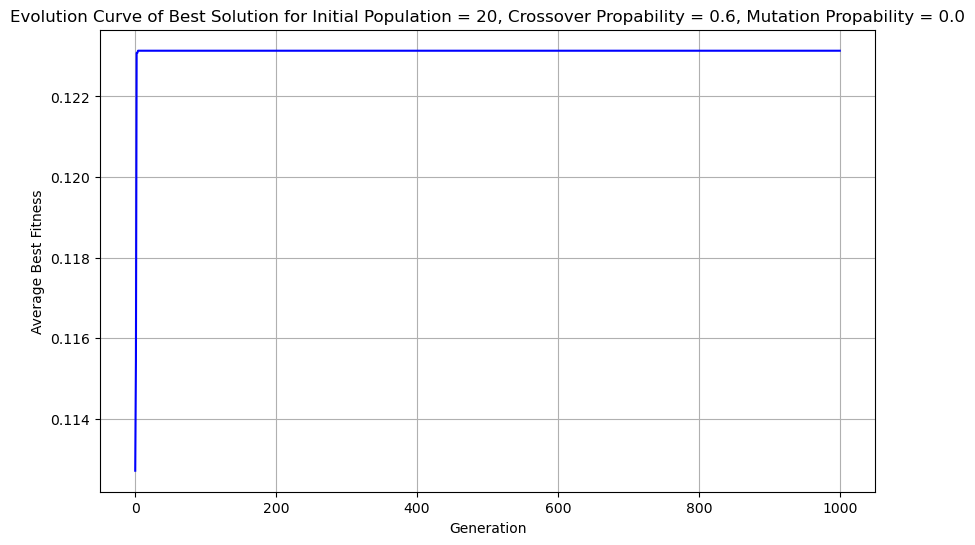

Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 56.
Execution2
Stopped Execution at Generation 17.
Execution3
Stopped Execution at Generation 91.
Execution4
Stopped Execution at Generation 110.
Execution5
Stopped Execution at Generation 228.
Execution6
Stopped Execution at Generation 272.
Execution7
Stopped Execution at Generation 97.
Execution8
Stopped Execution at Generation 43.
Execution9
Stopped Execution at Generation 117.
Execution10
Stopped Execution at Generation 20.


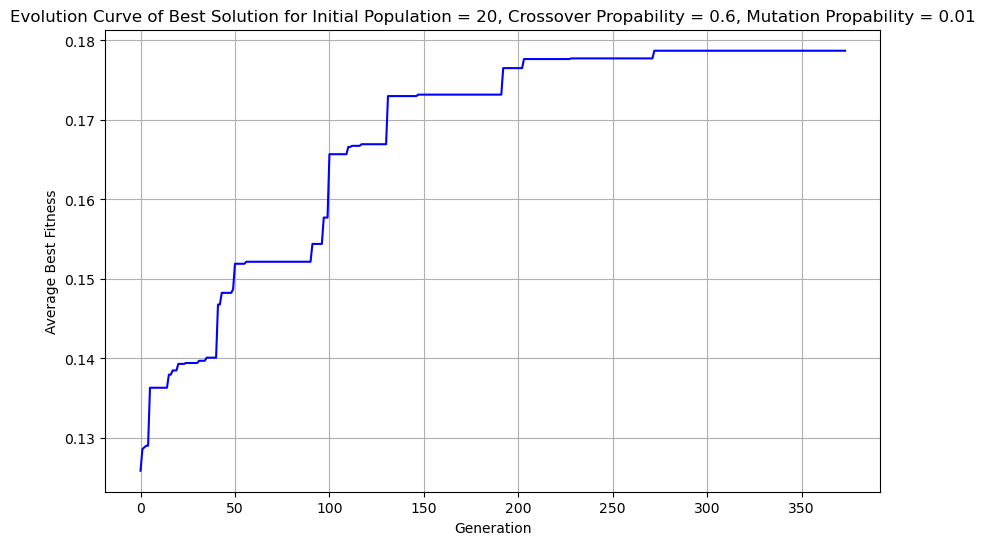

Execution for population of 20, crossover probability of 0.6 and mutation probability of 0.1


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 162.
Execution2
Stopped Execution at Generation 36.
Execution3
Stopped Execution at Generation 100.
Execution4
Stopped Execution at Generation 7.
Execution5
Stopped Execution at Generation 276.
Execution6
Stopped Execution at Generation 186.
Execution7
Stopped Execution at Generation 53.
Execution8
Stopped Execution at Generation 64.
Execution9
Stopped Execution at Generation 102.
Execution10
Stopped Execution at Generation 203.


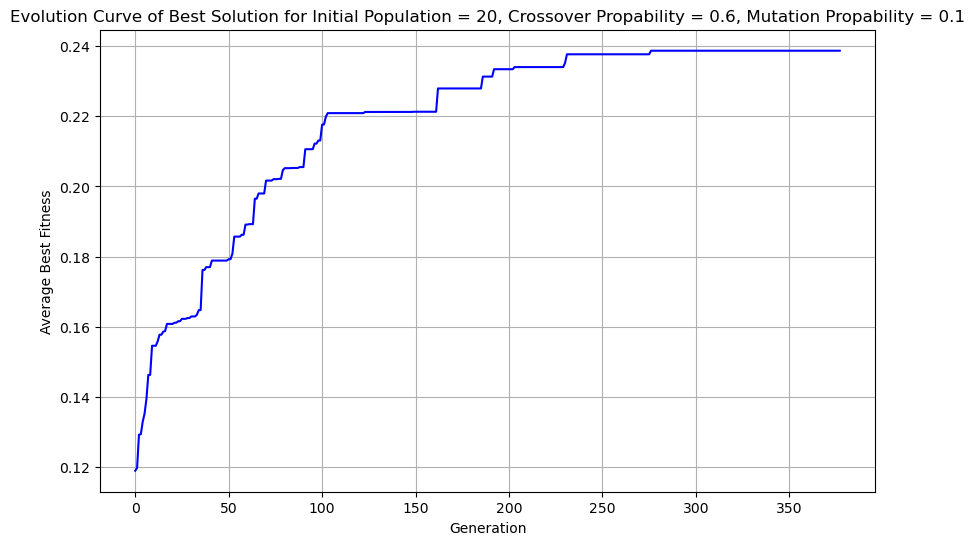

Execution for population of 20, crossover probability of 0.9 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 42.
Execution2
Stopped Execution at Generation 186.
Execution3
Stopped Execution at Generation 47.
Execution4
Stopped Execution at Generation 2.
Execution5
Stopped Execution at Generation 11.
Execution6
Stopped Execution at Generation 25.
Execution7
Stopped Execution at Generation 29.
Execution8
Stopped Execution at Generation 77.
Execution9
Stopped Execution at Generation 0.
Execution10
Stopped Execution at Generation 39.


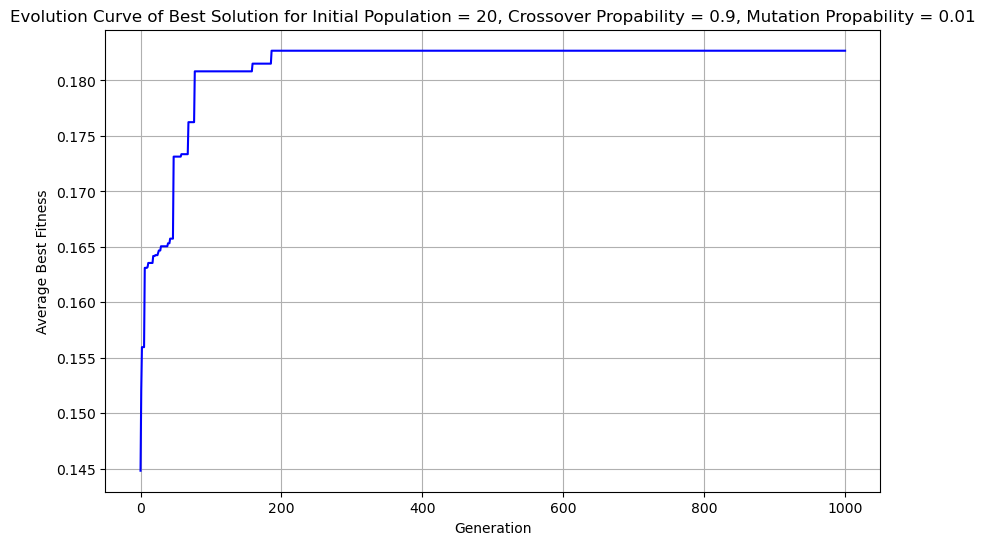

Execution for population of 20, crossover probability of 0.1 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 10.
Execution2
Stopped Execution at Generation 2.
Execution3
Stopped Execution at Generation 34.
Execution4
Stopped Execution at Generation 124.
Execution5
Stopped Execution at Generation 97.
Execution6
Stopped Execution at Generation 47.
Execution7
Stopped Execution at Generation 135.
Execution8
Stopped Execution at Generation 21.
Execution9
Stopped Execution at Generation 2.
Execution10
Stopped Execution at Generation 114.


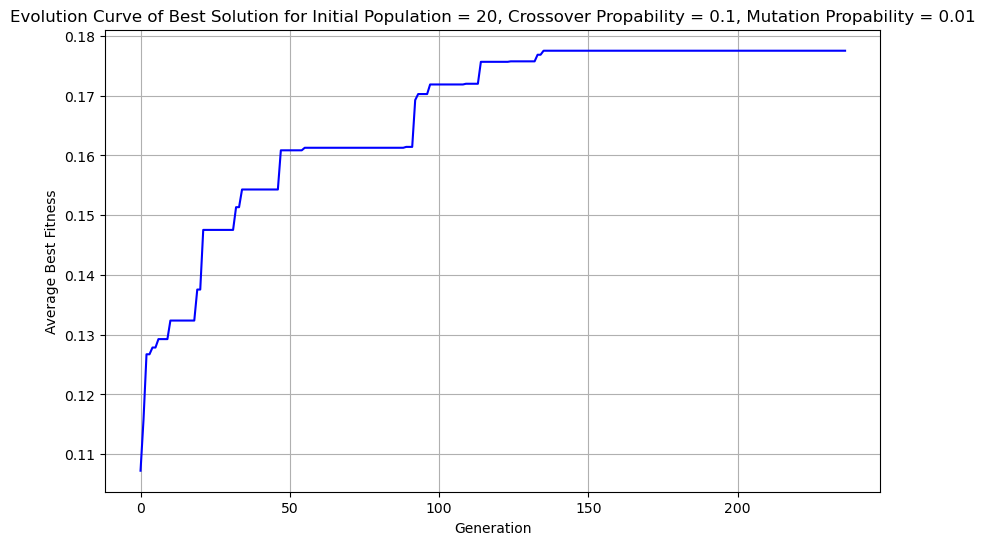

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.0


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 3.
Execution2
Stopped Execution at Generation 4.
Execution3
Stopped Execution at Generation 4.
Execution4
Stopped Execution at Generation 2.
Execution5
Stopped Execution at Generation 3.
Execution6
Stopped Execution at Generation 4.
Execution7
Stopped Execution at Generation 6.
Execution8
Stopped Execution at Generation 4.
Execution9
Stopped Execution at Generation 2.
Execution10
Stopped Execution at Generation 3.


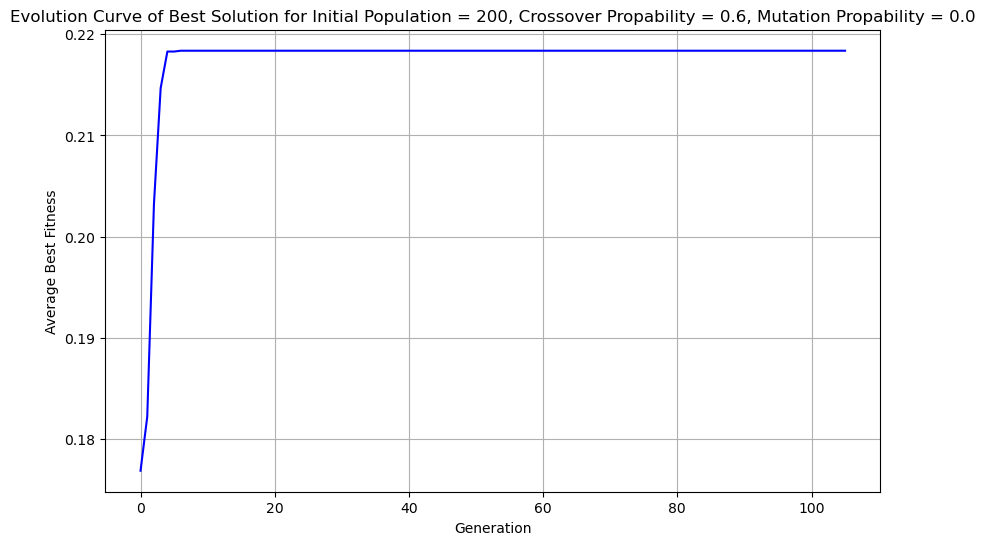

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 77.
Execution2
Stopped Execution at Generation 2.
Execution3
Stopped Execution at Generation 34.
Execution4
Stopped Execution at Generation 23.
Execution5
Stopped Execution at Generation 3.
Execution6
Stopped Execution at Generation 101.
Execution7
Stopped Execution at Generation 5.
Execution8
Stopped Execution at Generation 26.
Execution9
Stopped Execution at Generation 163.
Execution10
Stopped Execution at Generation 72.


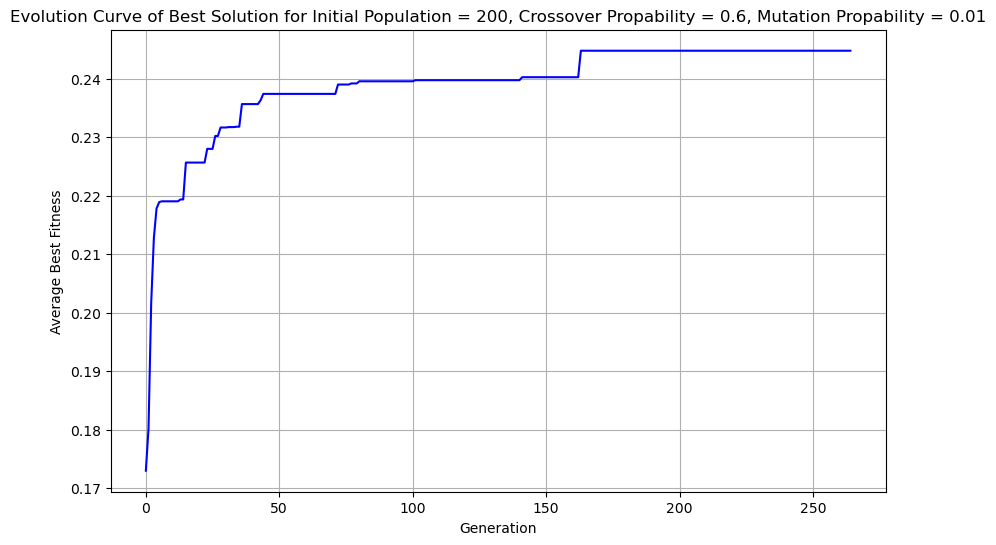

Execution for population of 200, crossover probability of 0.6 and mutation probability of 0.1


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 19.
Execution2
Stopped Execution at Generation 76.
Execution3
Stopped Execution at Generation 123.
Execution4
Stopped Execution at Generation 57.
Execution5
Stopped Execution at Generation 118.
Execution6
Stopped Execution at Generation 7.
Execution7
Stopped Execution at Generation 19.
Execution8
Stopped Execution at Generation 86.
Execution9
Stopped Execution at Generation 55.
Execution10
Stopped Execution at Generation 3.


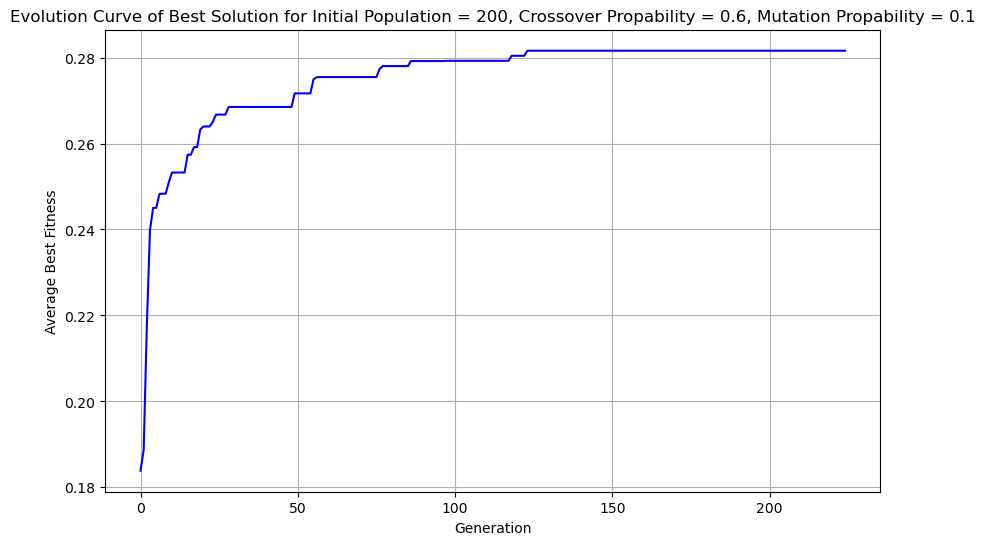

Execution for population of 200, crossover probability of 0.9 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 112.
Execution2
Stopped Execution at Generation 217.
Execution3
Stopped Execution at Generation 2.
Execution4
Stopped Execution at Generation 99.
Execution5
Stopped Execution at Generation 141.
Execution6
Stopped Execution at Generation 22.
Execution7
Stopped Execution at Generation 3.
Execution8
Stopped Execution at Generation 143.
Execution9
Stopped Execution at Generation 52.
Execution10
Stopped Execution at Generation 69.


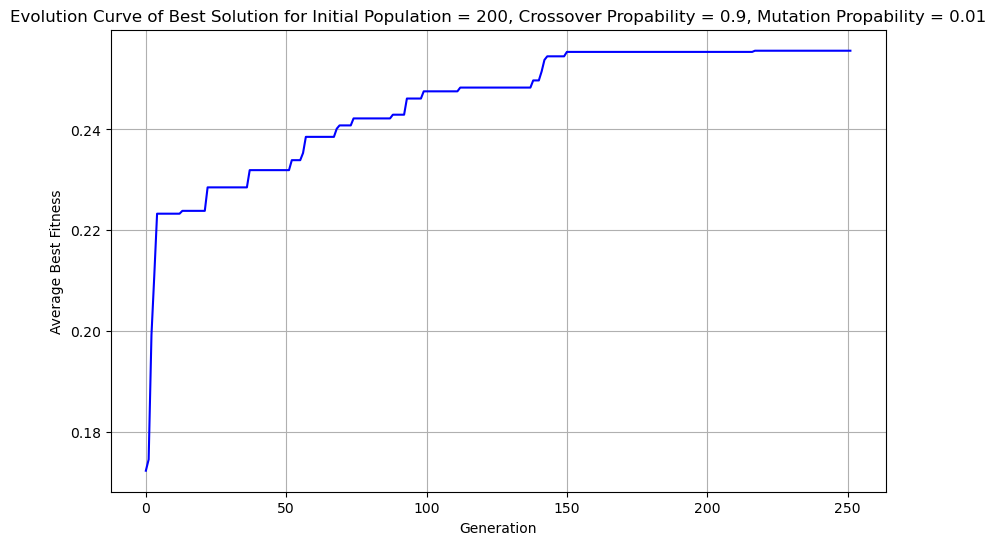

Execution for population of 200, crossover probability of 0.1 and mutation probability of 0.01


c:\Users\kwnka\miniconda3\envs\computIntel\lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


Execution1
Stopped Execution at Generation 6.
Execution2
Stopped Execution at Generation 61.
Execution3
Stopped Execution at Generation 60.
Execution4
Stopped Execution at Generation 139.
Execution5
Stopped Execution at Generation 93.
Execution6
Stopped Execution at Generation 3.
Execution7
Stopped Execution at Generation 2.
Execution8
Stopped Execution at Generation 3.
Execution9
Stopped Execution at Generation 23.
Execution10
Stopped Execution at Generation 2.


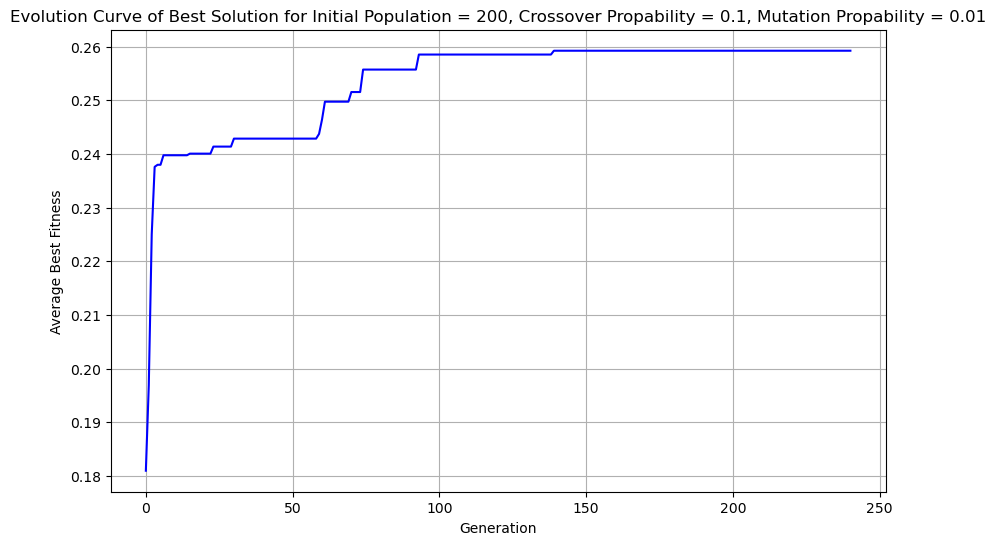

In [7]:
best_solution_per_instance = []
stopping_generations = []

parameters = [[20,0.6,0.0],
              [20,0.6,0.01],
              [20,0.6,0.1],
              [20,0.9,0.01],
              [20,0.1,0.01],
              [200,0.6,0.0],
              [200,0.6,0.01],
              [200,0.6,0.1],
              [200,0.9,0.01],
              [200,0.1,0.01]]

for parameter in parameters:
    print(f"Execution for population of {parameter[0]}, crossover probability of {parameter[1]} and mutation probability of {parameter[2]}")
    
    initial_populations = ul.create_initial_populations(10,parameter[0])
    ga_instances = ul.set_ga_instances(initial_populations, 1000, parameter[1], parameter[2], fitness_func, early_stopping_callback)
    gen_fitness,solution,mean_ending_generation = ul.run_instances(ga_instances)
    best_solution_per_instance.append(solution)
    stopping_generations.append(mean_ending_generation)
    ul.plot_evolution_curve(gen_fitness, parameter[0], parameter[1], parameter[2])
